In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from ipywidgets import interact
from skimage.transform import resize
from fastai import *
from fastai.vision.all import *

import sys
# import band plotter
sys.path.append('..')
from src.band_plotters import plot, DATA_DIRECTORY, plot_from_bands_picture, MAX_ENERGY_MINUS_EFERMI_NEAR_EFERMI, MIN_ENERGY_MINUS_EFERMI_NEAR_EFERMI, plot_from_bands_tensor
from src.Tiff32Image import Tiff32Image

## Constants and Selected Values

In [2]:
THRESHOLD = 8 # eV
RERUN = False

MAX_BANDS_NEAR_EFERMI =  189
MAX_BANDS =  260
MAX_WIDTH =  126
# NOW STORED IN band_plotters:
# MAX_ENERGY_MINUS_EFERMI_NEAR_EFERMI =  28.8 
# MIN_ENERGY_MINUS_EFERMI_NEAR_EFERMI =  -19.3
MAX_ENERGY_MINUS_EFERMI =  39.0
MIN_ENERGY_MINUS_EFERMI =  -103.5

# Used for images
SELECTED_WIDTH = 128
SELECTED_HEIGHT = 224

### Determining Constants for Image Processing

In [3]:
if RERUN:
    df_template = pd.read_csv("../fingerprints/template.csv", index_col="ID")
    MAX_BANDS = 0
    MAX_WIDTH = 0
    MAX_BANDS_NEAR_EFERMI = 0
    MAX_ENERGY_MINUS_EFERMI = 0
    MIN_ENERGY_MINUS_EFERMI = 0
    MAX_ENERGY_MINUS_EFERMI_NEAR_EFERMI = 0
    MIN_ENERGY_MINUS_EFERMI_NEAR_EFERMI = 0
    
    
    for i, material_id in enumerate(df_template.index):
        file_name = DATA_DIRECTORY/f"bands/{material_id}.json"
        bands_dict=json.load(open(file_name))
        energy_minus_efermi = np.array(bands_dict["bands"]["1"]) - bands_dict["efermi"]
        
        # determine max height of images
        distance_from_efermi = np.abs(energy_minus_efermi)
        mask = (distance_from_efermi < THRESHOLD).any(axis=1)
        if MAX_BANDS_NEAR_EFERMI < mask.sum():
            MAX_BANDS_NEAR_EFERMI = mask.sum()
            print(f"{material_id}: new max height with threshold ({THRESHOLD}): {MAX_BANDS_NEAR_EFERMI}")
        
        if MAX_BANDS < energy_minus_efermi.shape[0]:
            MAX_BANDS = energy_minus_efermi.shape[0]
            print(f"{material_id}: new max height without theshold: {MAX_BANDS}")
            
        if MAX_WIDTH < energy_minus_efermi.shape[1]:
            MAX_WIDTH = energy_minus_efermi.shape[1]
            print(f"{material_id}: new max width: {MAX_WIDTH}")
            
        if MAX_ENERGY_MINUS_EFERMI_NEAR_EFERMI < energy_minus_efermi[mask].max():
            MAX_ENERGY_MINUS_EFERMI_NEAR_EFERMI = energy_minus_efermi[mask].max()
            print(f"{material_id}: new max energy with threshold ({THRESHOLD}): {MAX_ENERGY_MINUS_EFERMI_NEAR_EFERMI}")
            
        if MIN_ENERGY_MINUS_EFERMI_NEAR_EFERMI > energy_minus_efermi[mask].min():
            MIN_ENERGY_MINUS_EFERMI_NEAR_EFERMI = energy_minus_efermi[mask].min()
            print(f"{material_id}: new max energy with threshold ({THRESHOLD}): {MIN_ENERGY_MINUS_EFERMI_NEAR_EFERMI}")
            
        if MAX_ENERGY_MINUS_EFERMI < energy_minus_efermi.max():
            MAX_ENERGY_MINUS_EFERMI = energy_minus_efermi.max()
            print(f"{material_id}: new max energy without threshold: {MAX_ENERGY_MINUS_EFERMI}")
            
        if MIN_ENERGY_MINUS_EFERMI > energy_minus_efermi.min():
            MIN_ENERGY_MINUS_EFERMI = energy_minus_efermi.min()
            print(f"{material_id}: new min energy without threshold: {MIN_ENERGY_MINUS_EFERMI}")
            
        if i % 200 == 0:
            print(i, "/", len(df_template))
            
        
    print("MAX_BANDS_NEAR_EFERMI = ", MAX_BANDS_NEAR_EFERMI)
    print("MAX_BANDS = ", MAX_BANDS)
    print("MAX_WIDTH = ", MAX_WIDTH)
    print("MAX_ENERGY_MINUS_EFERMI_NEAR_EFERMI = ", MAX_ENERGY_MINUS_EFERMI_NEAR_EFERMI)
    print("MIN_ENERGY_MINUS_EFERMI_NEAR_EFERMI = ", MIN_ENERGY_MINUS_EFERMI_NEAR_EFERMI)
    print("MAX_ENERGY_MINUS_EFERMI = ", MAX_ENERGY_MINUS_EFERMI)
    print("MIN_ENERGY_MINUS_EFERMI = ", MIN_ENERGY_MINUS_EFERMI)

## Visualizing Energy Values

In [4]:
def get_bands_that_come_near_fermi_level(bands_dict, threshold=THRESHOLD):
    '''
    band_dict["bands"]["1"] - band energy eigenvalues
    band_dict["efermi"] - fermi energy
    threshold - distance that bands must approach (at any point!) to be included
    '''
    energy_minus_efermi = np.array(bands_dict["bands"]["1"]) - bands_dict["efermi"]
    distance_from_efermi = np.abs(energy_minus_efermi)
    mask = (distance_from_efermi < 8).any(axis=1)
    return energy_minus_efermi[mask]

In [5]:
def show(x):

    example = DATA_DIRECTORY/f"bands/2dm-{x}.json"
    bands_dict=json.load(open(example))
    bands_minus_efermi = np.array(bands_dict["bands"]["1"]) - bands_dict["efermi"]
    plt.imshow(bands_minus_efermi)
    plt.show()
    bands_minus_efermi_in_threshold = get_bands_that_come_near_fermi_level(bands_dict)
    plt.imshow(bands_minus_efermi_in_threshold)

interact(show, x=258)

interactive(children=(IntSlider(value=258, description='x', max=774, min=-258), Output()), _dom_classes=('widg…

<function __main__.show(x)>

## Messing With Resizing
All Images must be the same size. Resizing should not mess up the band structure plots for our band reconstruction to be physically equivalent!

In [6]:
example_material_id = "2dm-492"
example = DATA_DIRECTORY/f"bands/{example_material_id}.json"
bands_dict=json.load(open(example))
energy_minus_efermi_in_threshold = get_bands_that_come_near_fermi_level(bands_dict)

resized =resize(energy_minus_efermi_in_threshold, (SELECTED_HEIGHT, SELECTED_WIDTH), preserve_range=True, mode="edge", order=0)

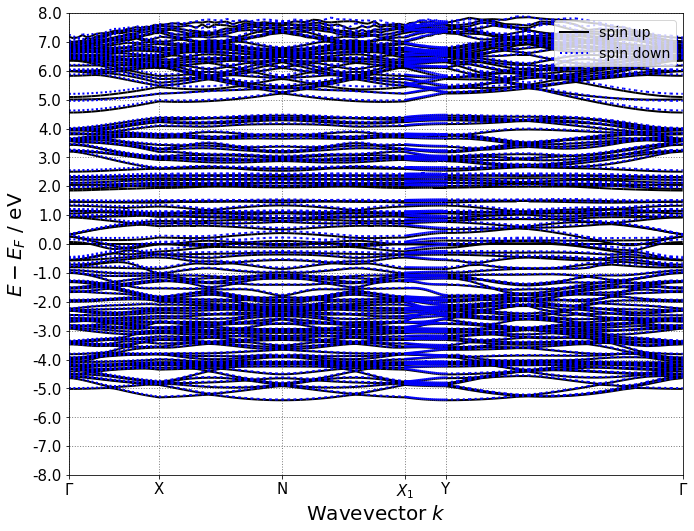

In [7]:
plot(example_material_id, bs_projection=None, dos=False, e_bounds=[-8, +8])

Dimensions of energy array don't match those of 2dm-492: resizing.


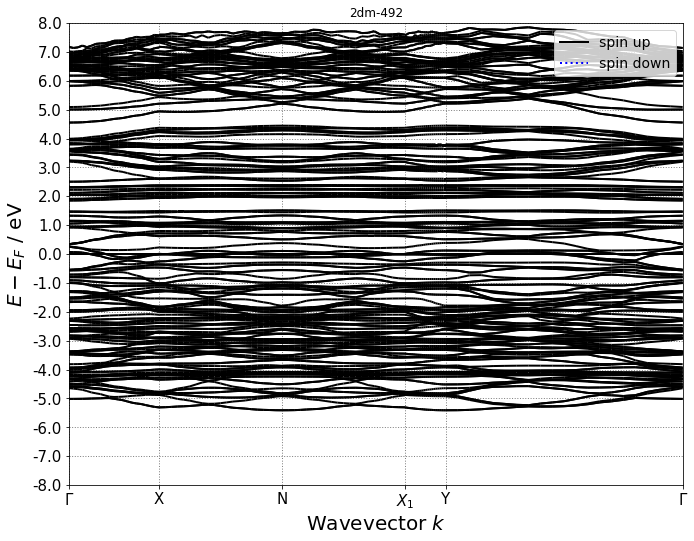

In [8]:
plot_from_bands_picture(example_material_id, resized, e_bounds=[-8, +8])

Resizing seems to be fine - now we need to save the images as PNGs and check they can be loaded properly.

## Saving Example as Image and Checking it can be Loaded

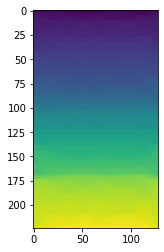

In [9]:
plt.imshow(resized)

(36998.95299383264, 18926.143960568606)

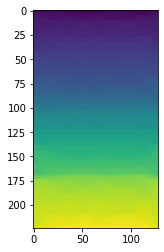

In [10]:
resized_int = (2**16-1) * (resized - MIN_ENERGY_MINUS_EFERMI_NEAR_EFERMI) / (MAX_ENERGY_MINUS_EFERMI_NEAR_EFERMI - MIN_ENERGY_MINUS_EFERMI_NEAR_EFERMI)
plt.imshow(resized_int)
resized_int.max(), resized_int.min()

In [11]:
from skimage import io
resized_int = resized_int.astype(np.uint16)
io.imsave('output.tiff', resized_int)

(array([[19462, 19462, 19465, ..., 19479, 19466, 19462],
        [19462, 19462, 19465, ..., 19479, 19466, 19462],
        [19972, 19957, 19923, ..., 19797, 19909, 19972],
        ...,
        [35860, 35829, 35870, ..., 36007, 35896, 35867],
        [36078, 36005, 36047, ..., 36110, 36054, 36015],
        [36078, 36005, 36047, ..., 36110, 36054, 36015]], dtype=uint16),
 array([[19462, 19462, 19465, ..., 19479, 19466, 19462],
        [19462, 19462, 19465, ..., 19479, 19466, 19462],
        [19972, 19957, 19923, ..., 19797, 19909, 19972],
        ...,
        [35860, 35829, 35870, ..., 36007, 35896, 35867],
        [36078, 36005, 36047, ..., 36110, 36054, 36015],
        [36078, 36005, 36047, ..., 36110, 36054, 36015]], dtype=uint16))

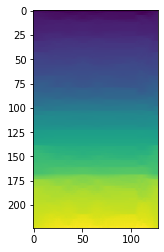

In [12]:
# test it can be loaded load
loaded = io.imread("output.tiff", np.uint16)
assert((loaded == resized_int).all())
plt.imshow(loaded)
loaded, resized_int

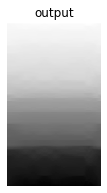

In [13]:
datablock = DataBlock(
    blocks=(ImageBlock(cls=Tiff32Image), ImageBlock(cls=Tiff32Image), CategoryBlock), 
    get_items=get_image_files,
    n_inp=1,
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    # item_tfms=[Resize(256)],
    get_y = [lambda x: x, lambda x: str(x)[:-5]],
    batch_tfms=[IntToFloatTensor(div=2**16-1),],
        )
dls = datablock.dataloaders(".", bs=1)
dls.show_batch()

In [14]:
xb, yb, label = dls.one_batch()
xb, dls.vocab[label]

(TensorImageBW([[[[0.2970, 0.2970, 0.2970,  ..., 0.2972, 0.2970, 0.2970],
                  [0.2970, 0.2970, 0.2970,  ..., 0.2972, 0.2970, 0.2970],
                  [0.3048, 0.3045, 0.3040,  ..., 0.3021, 0.3038, 0.3048],
                  ...,
                  [0.5472, 0.5467, 0.5473,  ..., 0.5494, 0.5477, 0.5473],
                  [0.5505, 0.5494, 0.5500,  ..., 0.5510, 0.5501, 0.5496],
                  [0.5505, 0.5494, 0.5500,  ..., 0.5510, 0.5501, 0.5496]]]],
               device='cuda:0'),
 (#1) ['output'])

Dimensions of energy array don't match those of 2dm-492: resizing.


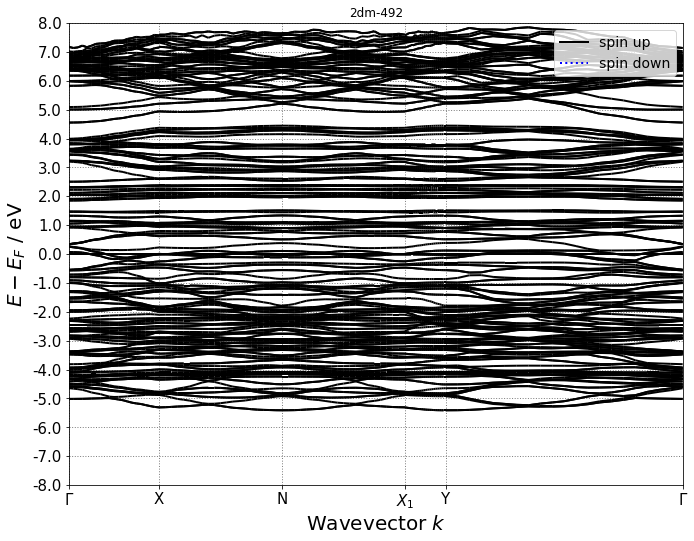

In [15]:
plot_from_bands_tensor(example_material_id, xb[0, 0], e_bounds=[-8, +8])

## Saving All Images

In [16]:
df_template = pd.read_csv("../fingerprints/template.csv", index_col="ID")
latest_material_that_already_exists = None

for i, material_id in enumerate(df_template.index):
    input_file_path = DATA_DIRECTORY/f"bands/{material_id}.json"
    output_file_path = DATA_DIRECTORY/f"images/energies{THRESHOLD}/{material_id}.tiff"
    
    if output_file_path.exists():
        latest_material_that_already_exists = material_id
        continue;
    elif latest_material_that_already_exists:
        print(f"All images up to {latest_material_that_already_exists}.tiff already exist.")
        latest_material_that_already_exists = None
        
        
    
    bands_dict=json.load(open(input_file_path))
    energy_minus_efermi_in_threshold = get_bands_that_come_near_fermi_level(bands_dict)
    resized =resize(energy_minus_efermi_in_threshold, (SELECTED_HEIGHT, SELECTED_WIDTH), preserve_range=True, mode="edge", order=0)
    resized_int = (2**16-1) * (resized - MIN_ENERGY_MINUS_EFERMI_NEAR_EFERMI) / (MAX_ENERGY_MINUS_EFERMI_NEAR_EFERMI - MIN_ENERGY_MINUS_EFERMI_NEAR_EFERMI)
    resized_int = resized_int.astype(np.uint16)
    io.imsave(output_file_path, resized_int)
    
    if i % 200 == 0:
        print(i, "/", len(df_template))

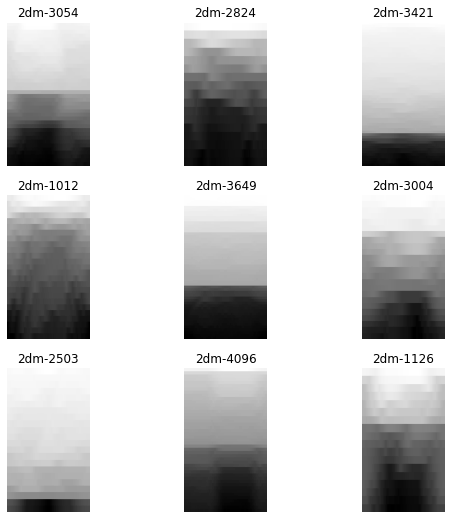

In [17]:
dls = DataBlock(
    blocks=(ImageBlock(cls=Tiff32Image), ImageBlock(cls=Tiff32Image), CategoryBlock), 
    get_items=get_image_files,
    n_inp=1,
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    # item_tfms=[Resize(256)],
    get_y = [lambda x: x, lambda x: str(x).split('/')[-1][:-5]],
    batch_tfms=[IntToFloatTensor(div=2**16-1),],
        ).dataloaders(DATA_DIRECTORY/f"images/energies{THRESHOLD}", bs=32)

dls.show_batch()